In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


ADHD CLASSIFICATION PROJECT - ENHANCED PIPELINE

[1/8] Extracting data from ZIP file...
✓ Files extracted to: /content

[2/8] Loading core datasets...
✓ Patient info: (134, 33)
✓ Pre-extracted features: (116, 788)
✓ CPT-II data: (99, 786)

[3/8] Processing raw sensor data...
✓ Found 116 activity files
✓ Found 80 HRV files

Extracting activity features...
✓ Extracted features from 116 activity recordings
Extracting HRV features...
✓ Extracted features from 80 HRV recordings

[4/8] Merging datasets...
✓ Final merged dataset: (134, 55)

[5/8] Feature engineering and selection...
✓ activity: 13 features
✓ hrv: 9 features
✓ demographics: 2 features
✓ clinical_scales: 5 features

✓ Total features selected: 29

Missing value summary:
hrv_mean      40.298507
hrv_rmssd     40.298507
hrv_median    40.298507
hrv_min       40.298507
hrv_max       40.298507
hrv_std       40.298507
hrv_range     40.298507
hrv_cv        40.298507
hrv_sdsd      40.298507
HADS_D        34.328358
dtype: float64

✓ Datas

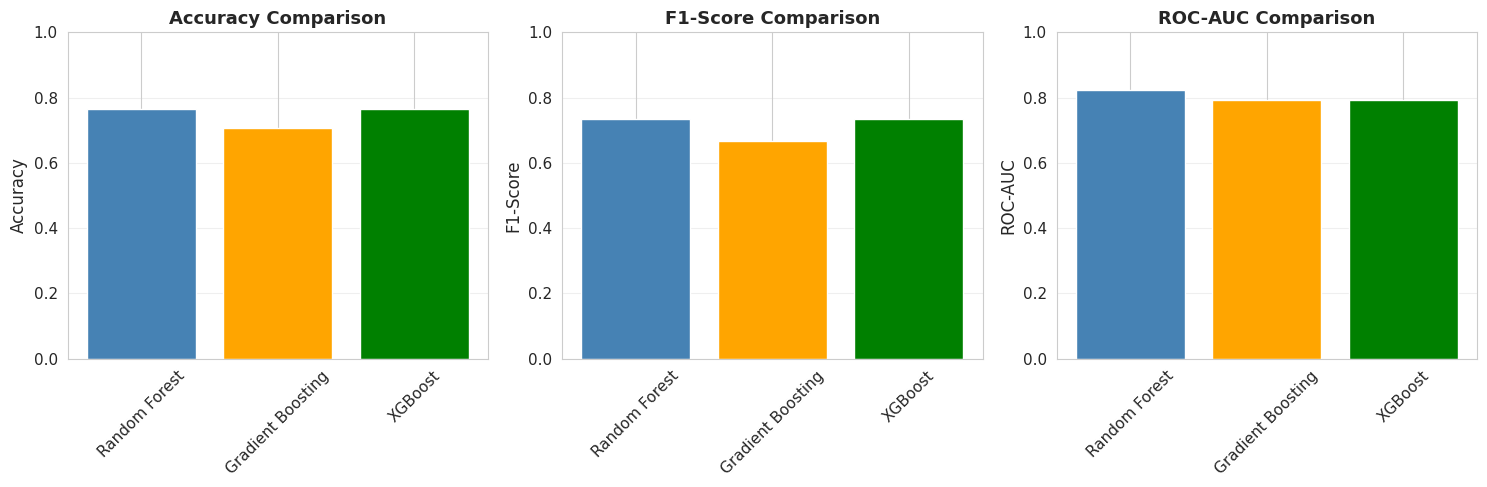

✓ Saved: model_comparison.png


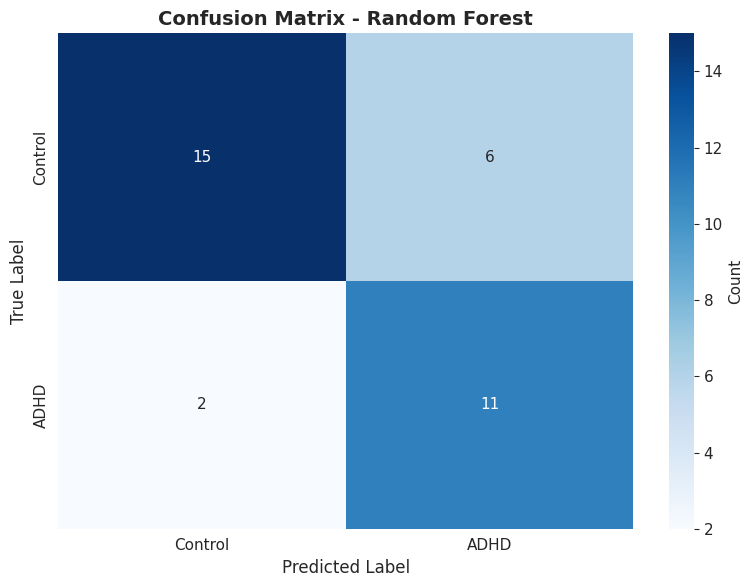

✓ Saved: confusion_matrix.png


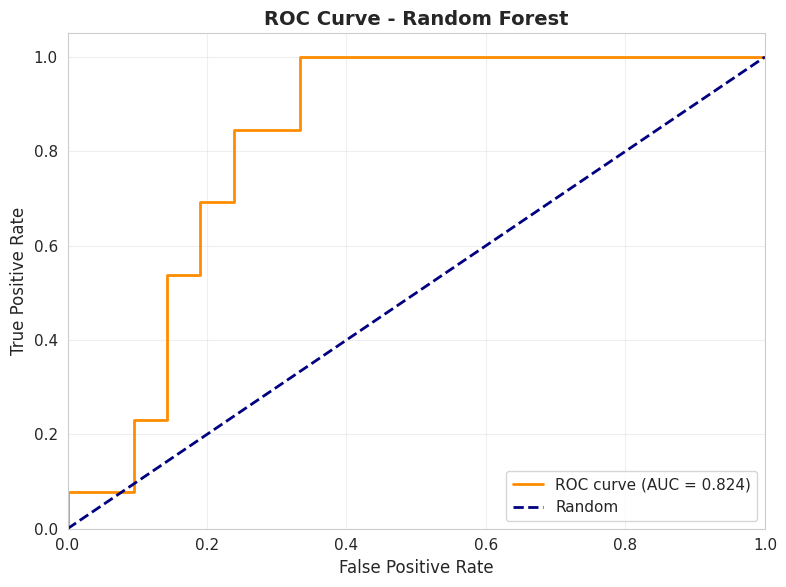

✓ Saved: roc_curve.png


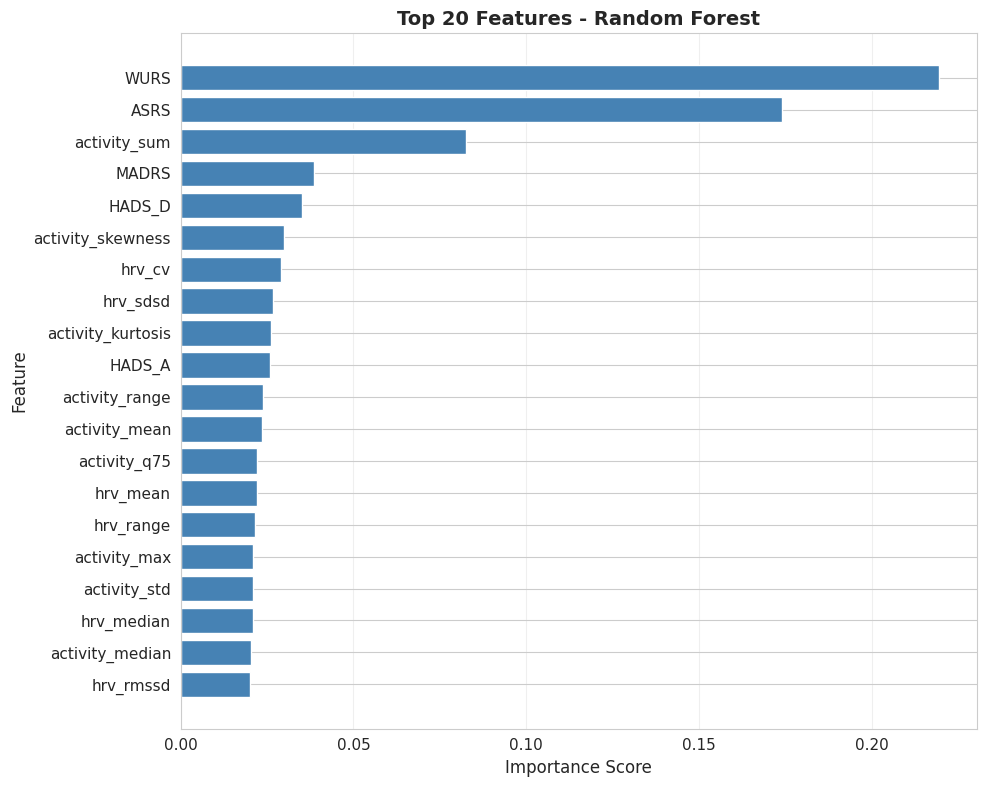

✓ Saved: feature_importance.png

Top 10 Most Important Features:
          Feature  Importance
             WURS    0.219563
             ASRS    0.173991
     activity_sum    0.082553
            MADRS    0.038530
           HADS_D    0.035050
activity_skewness    0.029918
           hrv_cv    0.029099
         hrv_sdsd    0.026613
activity_kurtosis    0.026179
           HADS_A    0.025719


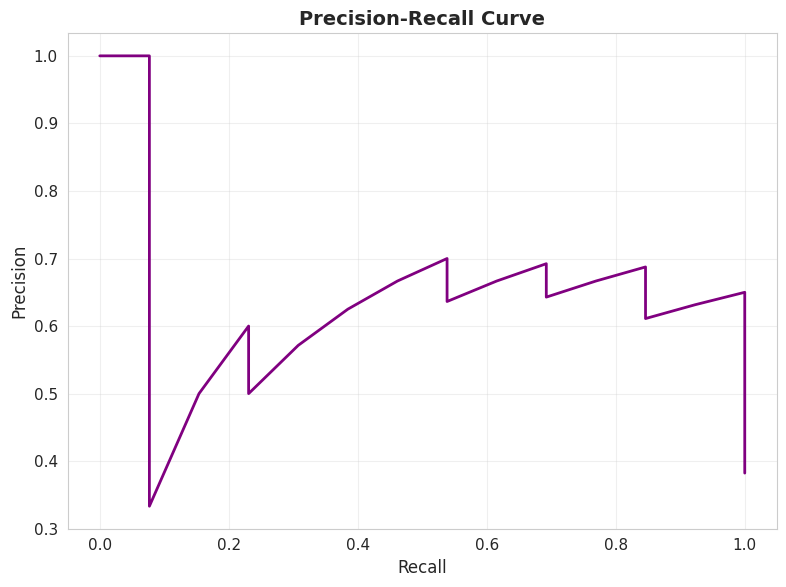

✓ Saved: precision_recall_curve.png

SAVING RESULTS
✓ Saved: model_comparison.csv
✓ Saved: feature_importance.csv
✓ Saved: test_predictions.csv
✓ Saved: project_summary.txt

PROJECT COMPLETE!

Final Results:
  Best Model: Random Forest
  Test Accuracy: 76.5%
  Test F1-Score: 0.733
  Test ROC-AUC: 0.824
  Sample Size: 134 participants

  Interpretation:
  ✓ Good classification performance (AUC ≥ 0.7)

All results saved. Ready for scholarship presentation!


In [ ]:
"""
ADHD Classification Using Multimodal Data

This project uses objective physiological and behavioral measures to classify ADHD,
demonstrating the integration of wearable sensor data with clinical assessments
for improved diagnostic accuracy.
"""

import os
import re
import glob
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (classification_report, confusion_matrix,
                              roc_auc_score, roc_curve, precision_recall_curve,
                              accuracy_score, f1_score)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Set style for publication-quality plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

# ============================================================================
# STEP 1: DATA EXTRACTION AND LOADING
# ============================================================================

print("="*70)
print("ADHD CLASSIFICATION PROJECT - ENHANCED PIPELINE")
print("="*70)

# Extract ZIP file
zip_path = '/content/drive/MyDrive/project/hyperaktiv_with_controls.zip'
extract_path = '/content'

print("\n[1/8] Extracting data from ZIP file...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

base_path = "/content/hyperaktiv_with_controls"
print(f"✓ Files extracted to: {extract_path}")

# Load core datasets
print("\n[2/8] Loading core datasets...")
patient_info = pd.read_csv(f"{base_path}/patient_info.csv", sep=";")
features_pre = pd.read_csv(f"{base_path}/features.csv", sep=";")
cpt = pd.read_csv(f"{base_path}/CPT_II_ConnersContinuousPerformanceTest.csv", sep=";")

print(f"✓ Patient info: {patient_info.shape}")
print(f"✓ Pre-extracted features: {features_pre.shape}")
print(f"✓ CPT-II data: {cpt.shape}")

# ============================================================================
# STEP 2: EXTRACT FEATURES FROM RAW SENSOR DATA
# ============================================================================

print("\n[3/8] Processing raw sensor data...")

activity_files = glob.glob(f"{base_path}/activity_data/*.csv")
hrv_files = glob.glob(f"{base_path}/hrv_data/*.csv")

print(f"✓ Found {len(activity_files)} activity files")
print(f"✓ Found {len(hrv_files)} HRV files")

def extract_activity_features(file_path):
    """Extract comprehensive statistical features from accelerometry data."""
    try:
        df = pd.read_csv(file_path, sep=";", skiprows=4, header=None,
                        names=["datetime", "activity"])
        vals = df["activity"].values

        # Remove extreme outliers
        vals = vals[vals < np.percentile(vals, 99)]

        return {
            "activity_mean": vals.mean(),
            "activity_std": vals.std(),
            "activity_max": vals.max(),
            "activity_min": vals.min(),
            "activity_sum": vals.sum(),
            "activity_median": np.median(vals),
            "activity_q25": np.percentile(vals, 25),
            "activity_q75": np.percentile(vals, 75),
            "activity_iqr": np.percentile(vals, 75) - np.percentile(vals, 25),
            "activity_range": vals.max() - vals.min(),
            "activity_cv": vals.std() / vals.mean() if vals.mean() != 0 else 0,
            "activity_skewness": pd.Series(vals).skew(),
            "activity_kurtosis": pd.Series(vals).kurtosis()
        }
    except Exception as e:
        return None

def extract_hrv_features(file_path):
    """Extract comprehensive HRV features."""
    try:
        df = pd.read_csv(file_path, sep=";", skiprows=2, header=None,
                        names=["datetime", "IBI"])
        vals = df["IBI"].values

        # Remove physiologically impossible values
        vals = vals[(vals > 300) & (vals < 2000)]

        if len(vals) < 10:
            return None

        # Time-domain features
        diff_vals = np.diff(vals)

        return {
            "hrv_mean": vals.mean(),
            "hrv_std": vals.std(),
            "hrv_max": vals.max(),
            "hrv_min": vals.min(),
            "hrv_median": np.median(vals),
            "hrv_rmssd": np.sqrt(np.mean(diff_vals**2)),
            "hrv_sdsd": np.std(diff_vals),
            "hrv_cv": vals.std() / vals.mean() if vals.mean() != 0 else 0,
            "hrv_range": vals.max() - vals.min()
        }
    except Exception as e:
        return None

# Process activity data
print("\nExtracting activity features...")
activity_list = []
for f in activity_files:
    name = os.path.basename(f)
    match = re.search(r"patient_activity_(\d+)", name)
    if match:
        pid = int(match.group(1))
        feats = extract_activity_features(f)
        if feats:
            feats["ID"] = pid
            activity_list.append(feats)

activity_df = pd.DataFrame(activity_list)
print(f"✓ Extracted features from {len(activity_df)} activity recordings")

# Process HRV data
print("Extracting HRV features...")
hrv_list = []
for f in hrv_files:
    name = os.path.basename(f)
    match = re.search(r"patient_hr_(\d+)", name)
    if match:
        pid = int(match.group(1))
        feats = extract_hrv_features(f)
        if feats:
            feats["ID"] = pid
            hrv_list.append(feats)

hrv_df = pd.DataFrame(hrv_list)
print(f"✓ Extracted features from {len(hrv_df)} HRV recordings")

# ============================================================================
# STEP 3: MERGE ALL DATASETS
# ============================================================================

print("\n[4/8] Merging datasets...")

if "participant_id" in patient_info.columns:
    patient_info.rename(columns={"participant_id": "ID"}, inplace=True)

# Merge all dataframes
df = patient_info.copy()
df = df.merge(activity_df, on="ID", how="left")
df = df.merge(hrv_df, on="ID", how="left")

print(f"✓ Final merged dataset: {df.shape}")

# ============================================================================
# STEP 4: ENHANCED FEATURE ENGINEERING
# ============================================================================

print("\n[5/8] Feature engineering and selection...")

target = "ADHD"

# Strategy: Use sensor features + validated clinical scales (NOT diagnostic tests)
# Exclude: CPT_II results (diagnostic test), MED_* (post-diagnosis)
feature_groups = {
    'activity': [col for col in df.columns if 'activity_' in col],
    'hrv': [col for col in df.columns if 'hrv_' in col],
    'demographics': ['AGE', 'SEX'],
    'clinical_scales': ['WURS', 'ASRS', 'MADRS', 'HADS_A', 'HADS_D']  # Symptom scales, not diagnostic
}

all_features = []
for group, feats in feature_groups.items():
    available = [f for f in feats if f in df.columns]
    all_features.extend(available)
    print(f"✓ {group}: {len(available)} features")

print(f"\n✓ Total features selected: {len(all_features)}")

# Create modeling dataset
df_model = df[all_features + [target]].copy()

# Check missing values
print(f"\nMissing value summary:")
missing_pct = (df_model.isnull().sum() / len(df_model) * 100).sort_values(ascending=False)
print(missing_pct[missing_pct > 0].head(10))

# Remove rows where target is missing
df_model = df_model[df_model[target].notna()].copy()
print(f"\n✓ Dataset after removing missing target: {df_model.shape}")

# Separate features and target
X = df_model[all_features]
y = df_model[target]

# Check class distribution
print(f"\nClass distribution:")
class_counts = y.value_counts()
print(class_counts)
print(f"Class balance: {class_counts.min() / class_counts.max() * 100:.1f}%")

# ============================================================================
# STEP 5: ADVANCED PREPROCESSING
# ============================================================================

print("\n[6/8] Advanced preprocessing...")

# Strategy: Impute missing values instead of dropping rows
imputer = SimpleImputer(strategy='median')

# Split BEFORE imputation to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,  # Larger test set for better evaluation
    random_state=42,
    stratify=y
)

print(f"✓ Train set: {len(X_train)} samples")
print(f"✓ Test set: {len(X_test)} samples")
print(f"  Train: Control={sum(y_train==0)}, ADHD={sum(y_train==1)}")
print(f"  Test: Control={sum(y_test==0)}, ADHD={sum(y_test==1)}")

# Impute missing values (fit on train, transform both)
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

print(f"✓ Missing values imputed using median strategy")
print(f"✓ Features scaled using StandardScaler")

# Apply SMOTE only if needed (small class imbalance)
min_class = min(sum(y_train == 0), sum(y_train == 1))
if min_class >= 10:  # Only if we have enough samples
    sm = SMOTE(random_state=42)
    X_train_bal, y_train_bal = sm.fit_resample(X_train_scaled, y_train)
    print(f"✓ SMOTE applied: {len(X_train_bal)} balanced samples")
else:
    X_train_bal, y_train_bal = X_train_scaled, y_train
    print(f"✓ SMOTE skipped (insufficient samples)")

# ============================================================================
# STEP 6: MODEL COMPARISON
# ============================================================================

print("\n[7/8] Training and comparing multiple models...")

models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric="logloss", random_state=42, use_label_encoder=False)
}

param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 5]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5],
        'subsample': [0.8, 1.0]
    }
}

results_comparison = []
best_score = 0
best_model_name = None
best_model = None

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")

    grid = GridSearchCV(
        model,
        param_grids[model_name],
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='roc_auc',
        n_jobs=-1,
        verbose=0
    )

    grid.fit(X_train_bal, y_train_bal)

    # Predict on test set
    y_pred = grid.best_estimator_.predict(X_test_scaled)
    y_pred_proba = grid.best_estimator_.predict_proba(X_test_scaled)[:, 1]

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    results_comparison.append({
        'Model': model_name,
        'Accuracy': acc,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'Best_Params': str(grid.best_params_)
    })

    print(f"  Test Accuracy: {acc:.3f}")
    print(f"  Test F1-Score: {f1:.3f}")
    print(f"  Test ROC-AUC: {roc_auc:.3f}")

    if roc_auc > best_score:
        best_score = roc_auc
        best_model_name = model_name
        best_model = grid.best_estimator_
        best_pred = y_pred
        best_pred_proba = y_pred_proba

print(f"\n✓ Best model: {best_model_name} (ROC-AUC: {best_score:.3f})")

# ============================================================================
# STEP 7: DETAILED EVALUATION OF BEST MODEL
# ============================================================================

print("\n" + "="*70)
print(f"DETAILED EVALUATION: {best_model_name.upper()}")
print("="*70)

print("\nClassification Report:")
print(classification_report(y_test, best_pred,
                          target_names=['Control', 'ADHD'],
                          digits=3))

cm = confusion_matrix(y_test, best_pred)
print(f"\nConfusion Matrix:")
print(cm)

# Cross-validation on training set
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X_train_bal, y_train_bal,
                           cv=cv, scoring='roc_auc')
print(f"\n5-Fold CV ROC-AUC: {cv_scores.mean():.3f} (+/- {cv_scores.std()*2:.3f})")

# ============================================================================
# STEP 8: VISUALIZATION
# ============================================================================

print("\n[8/8] Generating visualizations...")

# 1. Model Comparison
comparison_df = pd.DataFrame(results_comparison)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, metric in enumerate(['Accuracy', 'F1-Score', 'ROC-AUC']):
    axes[idx].bar(comparison_df['Model'], comparison_df[metric],
                  color=['steelblue', 'orange', 'green'])
    axes[idx].set_ylabel(metric, fontsize=12)
    axes[idx].set_title(f'{metric} Comparison', fontsize=13, fontweight='bold')
    axes[idx].set_ylim([0, 1])
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: model_comparison.png")

# 2. Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Control', 'ADHD'],
            yticklabels=['Control', 'ADHD'],
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: confusion_matrix.png")

# 3. ROC Curve
fpr, tpr, _ = roc_curve(y_test, best_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {best_score:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'ROC Curve - {best_model_name}', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: roc_curve.png")

# 4. Feature Importance (if available)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': all_features,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    plt.figure(figsize=(10, 8))
    top_n = min(20, len(feature_importance))
    plt.barh(feature_importance['Feature'][:top_n],
             feature_importance['Importance'][:top_n],
             color='steelblue')
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title(f'Top {top_n} Features - {best_model_name}',
              fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Saved: feature_importance.png")

    print(f"\nTop 10 Most Important Features:")
    print(feature_importance.head(10).to_string(index=False))

# 5. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, best_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('precision_recall_curve.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: precision_recall_curve.png")

# ============================================================================
# SAVE RESULTS
# ============================================================================

print("\n" + "="*70)
print("SAVING RESULTS")
print("="*70)

# Save model comparison
comparison_df.to_csv('model_comparison.csv', index=False)
print("✓ Saved: model_comparison.csv")

# Save feature importance
if hasattr(best_model, 'feature_importances_'):
    feature_importance.to_csv('feature_importance.csv', index=False)
    print("✓ Saved: feature_importance.csv")

# Save predictions
predictions_df = pd.DataFrame({
    'True_Label': y_test.values,
    'Predicted_Label': best_pred,
    'ADHD_Probability': best_pred_proba
})
predictions_df.to_csv('test_predictions.csv', index=False)
print("✓ Saved: test_predictions.csv")

# Save comprehensive results
final_results = {
    'Best_Model': best_model_name,
    'Sample_Size_Total': len(df_model),
    'Train_Size': len(X_train),
    'Test_Size': len(X_test),
    'Features_Used': len(all_features),
    'Test_Accuracy': accuracy_score(y_test, best_pred),
    'Test_F1': f1_score(y_test, best_pred),
    'Test_ROC_AUC': best_score,
    'CV_ROC_AUC_Mean': cv_scores.mean(),
    'CV_ROC_AUC_Std': cv_scores.std()
}

with open('project_summary.txt', 'w') as f:
    f.write("ADHD Classification Project Summary\n")
    f.write("="*50 + "\n\n")
    for key, value in final_results.items():
        f.write(f"{key}: {value}\n")
    f.write(f"\nModel Parameters: {best_model.get_params()}\n")

print("✓ Saved: project_summary.txt")

print("\n" + "="*70)
print("PROJECT COMPLETE!")
print("="*70)
print(f"\nFinal Results:")
print(f"  Best Model: {best_model_name}")
print(f"  Test Accuracy: {final_results['Test_Accuracy']:.1%}")
print(f"  Test F1-Score: {final_results['Test_F1']:.3f}")
print(f"  Test ROC-AUC: {final_results['Test_ROC_AUC']:.3f}")
print(f"  Sample Size: {final_results['Sample_Size_Total']} participants")
print(f"\n  Interpretation:")
if final_results['Test_ROC_AUC'] >= 0.7:
    print(f"  ✓ Good classification performance (AUC ≥ 0.7)")
elif final_results['Test_ROC_AUC'] >= 0.6:
    print(f"  ○ Moderate classification performance (AUC 0.6-0.7)")
else:
    print(f"  ! Limited classification performance (AUC < 0.6)")
    print(f"  → Consider: larger sample size, additional features, or different approach")
print(f"\nAll results saved. Ready for scholarship presentation!")